SQLite Database Initialization
This section initializes the SQLite database by creating necessary tables such as Items, Auctions, and ActionEvents. It ensures the existence of the required tables and sets up the database schema.

File and Configuration Setup
Additionally, it creates other essential files and configurations needed for subsequent operations.

In [1]:
import os
import sys
import sqlite3
import json
import pandas as pd
import pickle
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from datetime import datetime
from tqdm import tqdm
from pathlib import Path

wd = Path(os.path.dirname(os.path.abspath("__file__"))).parent.resolve()
sys.path.append(str(wd))

from data.transformers import add_features, transform_data

In [ ]:
db_path = 'auction.db'
conn = sqlite3.connect(db_path)
cursor = conn.cursor()

cursor.execute('''
    CREATE TABLE IF NOT EXISTS Items (
        item_id INT PRIMARY KEY,
        item_name TEXT,
        quality TEXT,
        item_level INT,
        required_level INT,
        item_class TEXT,
        item_subclass TEXT,
        purchase_price_gold INT,
        purchase_price_silver INT,
        sell_price_gold INT,
        sell_price_silver INT,
        max_count INT,
        is_stackable INT
    )
''')

cursor.execute('''
    CREATE TABLE IF NOT EXISTS Auctions (
        auction_id INT PRIMARY KEY,
        bid INT,
        buyout INT,
        quantity INT,
        time_left TEXT,
        item_id INT
    )
''')

cursor.execute('''
    CREATE TABLE IF NOT EXISTS ActionEvents (
        auction_id INT,
        record DATETIME,
        PRIMARY KEY (auction_id, record),
        FOREIGN KEY (auction_id) REFERENCES Auctions(auction_id)
    )
''')

conn.commit()
conn.close()

In [ ]:
file_info = {}
data_dir = 'sample/'

for root, dirs, files in os.walk(data_dir):
    for filename in tqdm(files):
        filepath = os.path.join(root, filename)
        date = datetime.strptime(filename.split('.')[0], '%Y%m%dT%H')

        file_info[filepath] = date

file_info = {k: v for k, v in sorted(file_info.items(), key=lambda item: item[1])}
filenames = list(file_info.keys())

filenames[:5]

MySQL Items Data Retrieval
In this part, the script retrieves data from a MySQL database. It reads the MySQL database configuration from a JSON file, establishes a connection, and fetches data from the Items table. The retrieved data is then loaded into a Pandas DataFrame.

SQLite Database Update
After retrieving the data, the script connects to the SQLite database, deletes all existing records from the Items table, and appends the newly fetched data.

In [ ]:
db_path = 'auction.db'
data_dir = 'sample/'
db = sqlite3.connect(db_path)
cursor = db.cursor()
auction_ids = {}

for i, filepath in tqdm(enumerate(filenames)):
    print(f"Processing file {filepath} ({i+1}/{len(filenames)})")
    
    try:
        data = json.load(open(filepath, "r"))
    except (FileNotFoundError, json.JSONDecodeError) as e:
        print(f"Error reading file {filepath}: {e}")
        continue

    filename = filepath.split('/')[-1]
    auction_record = datetime.strptime(filename[:-5], "%Y%m%dT%H")

    if i == 0:
        auctions_data = []

        for auction in data["auctions"]:
            if auction["id"] not in auction_ids:
                auctions_data.append((auction["id"], auction["bid"], auction["buyout"], auction["quantity"], auction["time_left"], auction["item"]["id"]))
                auction_ids.update({auction["id"]: 1})

        try:
            cursor.executemany("""
                INSERT INTO Auctions (auction_id, bid, buyout, quantity, time_left, item_id)
                VALUES (?, ?, ?, ?, ?, ?)
            """, auctions_data)
        except sqlite3.Error as err:
            db.rollback()
            print(f"Error inserting auction data for file {filepath} in Auctions: {err}")

    action_events_data = []
    for auction in data["auctions"]:
        if auction["id"] in auction_ids:
            action_events_data.append((auction["id"], auction_record.strftime('%Y-%m-%d %H:%M:%S')))
            
    try:
        cursor.executemany("""
            INSERT OR REPLACE INTO ActionEvents (auction_id, record)
            VALUES (?, ?)
        """, action_events_data)
    except sqlite3.Error as err:
        db.rollback()
        print(f"Error inserting auction events for file {filepath} in ActionEvents: {err}")

db.commit()
cursor.close()
db.close()

Auction Data and Items Storage
This section processes JSON files containing auction data. It iterates through the files, extracts relevant information, and inserts it into the Auctions and ActionEvents tables of the SQLite database.

Data Import from Pandas DataFrame
Moreover, it initializes a connection to the SQLite database and imports data from a Pandas DataFrame into the Items table. This DataFrame is generated from MySQL database retrieval, ensuring the SQLite Items table is up-to-date.

In [ ]:
items_df = pd.read_csv('items.csv')
items = [tuple(x) for x in items_df.values]

try:
    db = sqlite3.connect(db_path)
    print("Connected to SQLite")
except sqlite3.Error as err:
    print(f"Error connecting to SQLite: {err}")

cursor = db.cursor()

cursor.execute('''
    DROP TABLE IF EXISTS Items
''')

cursor.execute('''
    CREATE TABLE IF NOT EXISTS Items (
        item_id INT PRIMARY KEY,
        item_name TEXT,
        quality TEXT,
        item_level INT,
        required_level INT,
        item_class TEXT,
        item_subclass TEXT,
        purchase_price_gold INT,
        purchase_price_silver INT,
        sell_price_gold INT,
        sell_price_silver INT,
        max_count INT,
        is_stackable INT
    )
''')

try:
    print(items[0])
    cursor.executemany("""
        INSERT OR REPLACE INTO Items (item_id, item_name, quality, item_level, required_level, item_class, item_subclass, purchase_price_gold, purchase_price_silver, sell_price_gold, sell_price_silver, max_count, is_stackable)
        VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)
    """, items)
    db.commit()
    print("Inserted items into SQLite: " + str(len(items)))
except sqlite3.Error as err:
    print(f"Error executing SQL query: {err}")

finally:
    cursor.close()
    db.close()

# Read auction.db
It is responsible for connecting to an SQLite database, executing a SQL query involving multiple tables, and retrieving the results. These results are stored in the variable

In [ ]:
db_path = 'auction.db'
conn = sqlite3.connect(db_path)
cursor = conn.cursor()

query = """
    SELECT
        a.auction_id,
        a.bid / 10000.0 AS bid_in_gold,
        a.buyout / 10000.0 AS buyout_in_gold,
        (a.buyout / 10000.0) / a.quantity AS unit_price,
        a.quantity,
        a.time_left,
        a.item_id,
        i.item_name,
        i.quality,
        i.item_class,
        i.item_subclass,
        i.is_stackable,
        i.purchase_price_gold,
        i.required_level,
        i.item_level,
        i.sell_price_gold,
        MIN(ae.record) AS first_appearance_timestamp,
        strftime('%Y', MIN(ae.record)) AS first_appearance_year,
        strftime('%m', MIN(ae.record)) AS first_appearance_month,
        strftime('%d', MIN(ae.record)) AS first_appearance_day,
        strftime('%H', MIN(ae.record)) AS first_appearance_hour,
        COUNT(*) AS hours_on_sale
    FROM Auctions a
    JOIN ActionEvents ae ON a.auction_id = ae.auction_id
    JOIN Items i ON i.item_id = a.item_id
    WHERE A.time_left <> 'SHORT'
    GROUP BY a.auction_id
"""

cursor.execute(query)
results = cursor.fetchall()

conn.close()

df = pd.DataFrame(results, columns=[i[0] for i in cursor.description])
df.head(10)

In [ ]:
df['time_left'].value_counts().plot(kind='bar')

In [ ]:
df = add_features(df)

In [ ]:
print(f'Dataframe shape before duplicates {df.shape}')

df = df.drop_duplicates(subset=['bid_in_gold', 'buyout_in_gold', 'quantity', 'time_left', 'first_appearance_timestamp', 'item_id'])
df = df[(df['time_left'] != 2)]

print(f'Dataframe shape after duplicates {df.shape}')

In [ ]:
X, y = transform_data(df)

df.head(5)

In [ ]:
df.columns

loads a trained model from a file, makes predictions on a data set, calculates the RMSE and displays the result

In [ ]:
pd.options.display.float_format = '{:.0f}'.format

with open('models/forest_model.pkl', 'rb') as model_file:
    model = pickle.load(model_file)

In [ ]:
predictions = model.predict(X)
df['prediction'] = predictions
df[['item_name', 'item_class', 'unit_price', 'bid_in_gold', 'buyout_in_gold', 'time_left', 'hours_on_sale', 'prediction']].head(10)

In [ ]:
from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(y, predictions)

print("MAE:", mae)

In [8]:
df[['item_name', 'item_class', 'unit_price', 'bid_in_gold', 'buyout_in_gold', 'item_id', 'quantity', 'first_appearance_timestamp', 'median_buyout_price',
       'median_bid_price', 'median_unit_price', 'rank_buyout_price',
       'rank_bid_price', 'rank_unit_price', 'avg_competitor_price',
       'std_competitor_price', 'competitor_count', 'lowest_competitor_price',
       'top_competitor_price', 'relative_price_difference',
       'relative_avg_price_difference', 'relative_buyout_difference',
       'relative_bid_difference', 'relative_price_to_lowest_competitor',
       'relative_price_to_top_competitor', 'time_left', 'hours_on_sale', 'prediction']].to_excel('MAE_6_45.xlsx', index=False)

# Error analysis

In [2]:
df_val = pd.read_excel('MAE_5_54.xlsx')
df_test = pd.read_excel('MAE_6_45.xlsx')

df_val['error'] = np.abs(df_val['hours_on_sale'] - df_val['prediction'])
df_test['error'] = np.abs(df_test['hours_on_sale'] - df_test['prediction'])

df_test.head()

,item_name,item_class,unit_price,bid_in_gold,buyout_in_gold,item_id,quantity,first_appearance_timestamp,median_buyout_price,median_bid_price,...,relative_price_difference,relative_avg_price_difference,relative_buyout_difference,relative_bid_difference,relative_price_to_lowest_competitor,relative_price_to_top_competitor,time_left,hours_on_sale,prediction,error
0,Mark of Kil'jaeden,Quest,0.500000,1.0000,2.5000,29425,5,2023-11-04 00:00:00,19.9800,18.9810,...,-0.783183,-1.352880,-0.874875,-0.947316,-0.499414,-0.799067,48,48,2.452158,45.547842
1,Elemental Water,Trade Goods,1.999800,1.8999,1.9998,7070,1,2023-11-04 00:00:00,4.9977,4.9976,...,-0.430224,-1.682904,-0.599856,-0.619837,-0.333381,-0.580922,48,48,2.485727,45.514273
2,Ghost Mushroom,Trade Goods,1.371680,6.8583,6.8584,8845,5,2023-11-04 00:00:00,4.8635,4.8634,...,-0.248403,-1.153521,0.410178,0.410186,-0.046849,-0.296358,48,48,2.511380,45.488620
3,Ghost Mushroom,Trade Goods,1.371650,2.7432,2.7433,8845,2,2023-11-04 00:00:00,4.8635,4.8634,...,-0.248419,-1.153623,-0.435941,-0.435950,-0.046870,-0.296373,48,48,2.511380,45.488620
4,Ghost Mushroom,Trade Goods,1.371667,4.1149,4.1150,8845,3,2023-11-04 00:00:00,4.8635,4.8634,...,-0.248410,-1.153566,-0.153901,-0.153905,-0.046858,-0.296365,48,48,2.511380,45.488620


In [8]:
df_test = df_test.sort_values(by='prediction', ascending=False)
df_test.head(10)

,item_name,item_class,unit_price,bid_in_gold,buyout_in_gold,item_id,quantity,first_appearance_timestamp,median_buyout_price,median_bid_price,...,relative_price_difference,relative_avg_price_difference,relative_buyout_difference,relative_bid_difference,relative_price_to_lowest_competitor,relative_price_to_top_competitor,time_left,hours_on_sale,prediction,error
1385,Steadfast Bracelets,Armor,56.4467,56.4467,56.4467,15590,1,2023-11-04 00:00:00,56.4465,56.44650,...,0.000004,0.577353,0.000004,0.000004,1.965580,0.000001,48,20,49.488300,29.488300
1392,Trickster's Pauldrons,Armor,56.4467,56.4467,56.4467,15368,1,2023-11-04 00:00:00,56.4467,56.44670,...,0.000000,0.654945,0.000000,0.000000,1.557871,0.000000,48,20,49.451200,29.451200
1224,Thistlefur Cloak,Armor,56.4467,56.4467,56.4467,14198,1,2023-11-04 00:00:00,56.4467,56.44670,...,0.000000,0.577350,0.000000,0.000000,1.515183,0.000000,48,19,49.437040,30.437040
1402,Outrunner's Shield,Armor,56.4467,56.4467,56.4467,15504,1,2023-11-04 00:00:00,56.4467,56.44670,...,0.000000,0.577350,0.000000,0.000000,1.965570,0.000000,48,20,49.391046,29.391046
1403,Durable Hat,Armor,56.4467,56.4467,56.4467,10289,1,2023-11-04 00:00:00,30.9818,29.43280,...,0.821931,1.356951,0.821931,0.917816,1.559139,0.341804,48,20,49.390264,29.390264
1231,Outrunner's Legguards,Armor,56.4467,56.4467,56.4467,15503,1,2023-11-04 00:00:00,56.4467,56.44670,...,0.000000,0.500000,0.000000,0.000000,0.830020,0.000000,48,19,49.384755,30.384755
1643,Dervish Leggings,Armor,56.4467,56.4467,56.4467,6607,1,2023-11-04 00:00:00,32.7233,31.08715,...,0.724970,1.138448,0.724970,0.815757,1.822335,0.132407,48,21,49.375112,28.375112
1238,Defender Cloak,Armor,56.4467,56.4467,56.4467,6575,1,2023-11-04 00:00:00,56.4467,56.44670,...,0.000000,0.577350,0.000000,0.000000,2.079997,0.000000,48,19,49.335600,30.335600
1443,Steadfast Bracelets,Armor,56.4465,56.4465,56.4465,15590,1,2023-11-04 00:00:00,56.4465,56.44650,...,0.000000,0.577347,0.000000,0.000000,1.965569,-0.000002,48,20,49.233663,29.233663
1250,Soldier's Wristguards,Armor,56.4467,56.4467,56.4467,6550,1,2023-11-04 00:00:00,56.4465,56.44650,...,0.000004,0.577354,0.000004,0.000004,1.504962,0.000001,48,19,49.224378,30.224378


In [4]:
df_test = df_test.sort_values(by='error', ascending=False)
df_test.head(10)

,item_name,item_class,unit_price,bid_in_gold,buyout_in_gold,item_id,quantity,first_appearance_timestamp,median_buyout_price,median_bid_price,...,relative_price_difference,relative_avg_price_difference,relative_buyout_difference,relative_bid_difference,relative_price_to_lowest_competitor,relative_price_to_top_competitor,time_left,hours_on_sale,prediction,error
81366,Mark of Kil'jaeden,Quest,0.500000,1.0000,2.5000,29425,5,2023-11-04 00:00:00,19.9800,18.98100,...,-0.783183,-1.352880,-0.874875,-0.947316,-0.499414,-0.799067,48,48,2.452158,45.547842
66912,Elemental Water,Trade Goods,1.999800,1.8999,1.9998,7070,1,2023-11-04 00:00:00,4.9977,4.99760,...,-0.430224,-1.682904,-0.599856,-0.619837,-0.333381,-0.580922,48,48,2.485727,45.514273
65658,Ghost Mushroom,Trade Goods,1.371680,6.8583,6.8584,8845,5,2023-11-04 00:00:00,4.8635,4.86340,...,-0.248403,-1.153521,0.410178,0.410186,-0.046849,-0.296358,48,48,2.511380,45.488620
65770,Ghost Mushroom,Trade Goods,1.371650,2.7432,2.7433,8845,2,2023-11-04 00:00:00,4.8635,4.86340,...,-0.248419,-1.153623,-0.435941,-0.435950,-0.046870,-0.296373,48,48,2.511380,45.488620
74191,Ghost Mushroom,Trade Goods,1.371667,4.1149,4.1150,8845,3,2023-11-04 00:00:00,4.8635,4.86340,...,-0.248410,-1.153566,-0.153901,-0.153905,-0.046858,-0.296365,48,48,2.511380,45.488620
81538,Mark of Sargeras,Quest,0.750000,1.0000,1.5000,30809,2,2023-11-04 00:00:00,9.4780,9.00415,...,-0.208944,-0.120265,-0.841739,-0.888940,-0.208272,-0.218652,48,48,2.524526,45.475474
92717,Greater Nether Essence,Trade Goods,9.290000,8.8200,9.2900,11175,1,2023-11-04 00:00:00,11.9985,11.39860,...,-0.225711,-0.641308,-0.225737,-0.226221,-0.154625,-0.285819,48,48,2.554018,45.445982
82702,Fel Iron Bomb,Trade Goods,0.291040,5.5298,5.8208,23736,20,2023-11-04 00:00:00,5.5320,5.26450,...,-0.028571,-0.370951,0.052205,0.050394,-0.026622,-0.250476,48,48,2.565881,45.434119
76268,Shadow Silk,Trade Goods,1.100000,11.0000,11.0000,10285,10,2023-11-04 00:00:00,9.9999,9.50000,...,-0.889999,-1.202711,0.100011,0.157895,-0.009009,-0.889999,48,48,2.715213,45.284787
92250,Soul Dust,Trade Goods,0.891500,16.9400,17.8300,11083,20,2023-11-04 00:00:00,17.8520,17.85200,...,-0.550927,-0.368533,-0.001232,-0.051087,-0.001232,-0.554161,48,48,2.740231,45.259769


In [ ]:
corr_matrix = df_val[['bid_in_gold', 'buyout_in_gold',
       'unit_price', 'quantity', 'time_left', 'item_id',
       'median_buyout_price', 'median_bid_price', 'median_unit_price',
       'rank_buyout_price', 'rank_bid_price', 'rank_unit_price',
       'avg_competitor_price', 'std_competitor_price', 'competitor_count',
       'lowest_competitor_price', 'top_competitor_price',
       'relative_price_difference', 'relative_avg_price_difference',
       'relative_buyout_difference', 'relative_bid_difference',
       'relative_price_to_lowest_competitor',
       'relative_price_to_top_competitor','hours_on_sale', 'prediction', 'error']].corr()

corr_matrix = corr_matrix[['prediction', 'hours_on_sale', 'error']]

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation with Prediction and Hours on Sale - MAE 5.54')
plt.show()

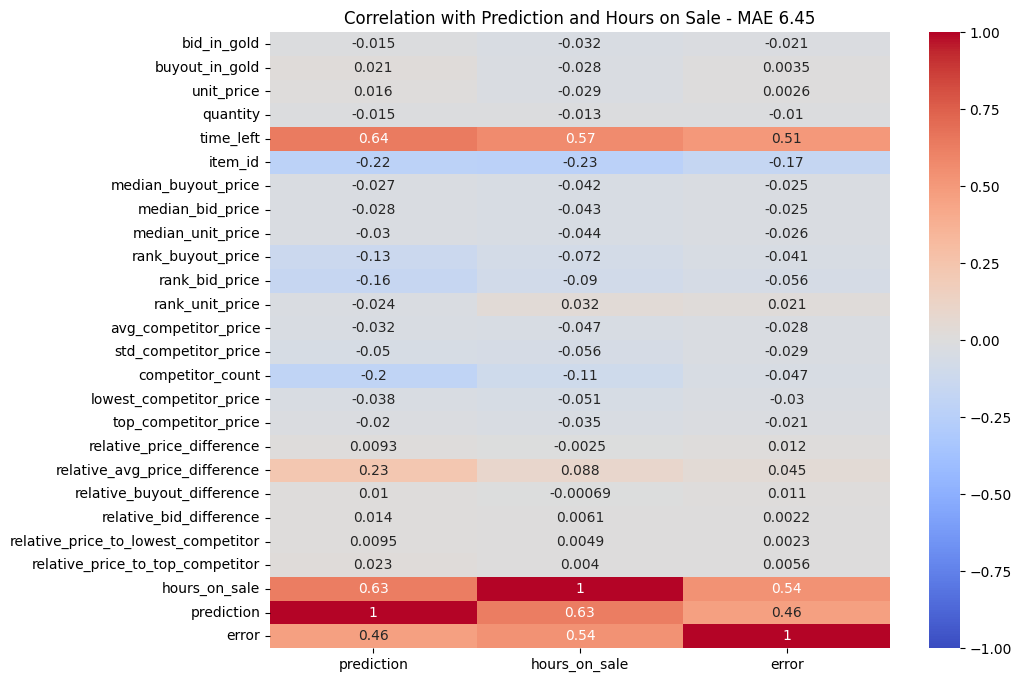

In [5]:
corr_matrix = df_test[['bid_in_gold', 'buyout_in_gold',
       'unit_price', 'quantity', 'time_left', 'item_id',
       'median_buyout_price', 'median_bid_price', 'median_unit_price',
       'rank_buyout_price', 'rank_bid_price', 'rank_unit_price',
       'avg_competitor_price', 'std_competitor_price', 'competitor_count',
       'lowest_competitor_price', 'top_competitor_price',
       'relative_price_difference', 'relative_avg_price_difference',
       'relative_buyout_difference', 'relative_bid_difference',
       'relative_price_to_lowest_competitor',
       'relative_price_to_top_competitor','hours_on_sale', 'prediction', 'error']].corr()

corr_matrix = corr_matrix[['prediction', 'hours_on_sale', 'error']]

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation with Prediction and Hours on Sale - MAE 6.45')
plt.show()

   time_left     error
0         24  3.022830
1         48  8.091958
   time_left      error
0         12   2.632007
1         24   2.931505
2         48  10.184960


ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (2,) and arg 1 with shape (3,).

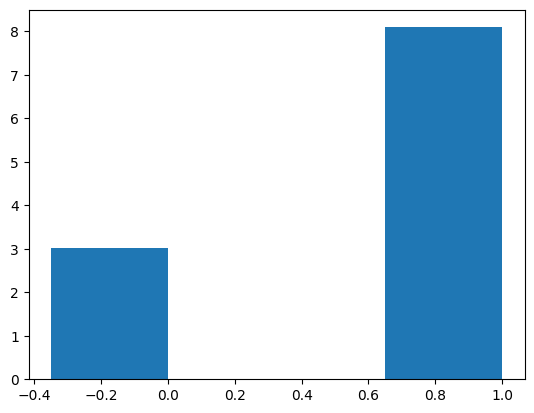

In [6]:
mean_errors_val = df_val.groupby('time_left')['error'].mean().reset_index()
mean_errors_test = df_test.groupby('time_left')['error'].mean().reset_index()

print(mean_errors_val)
print(mean_errors_test)

fig, ax = plt.subplots()

# Create a bar plot with the validation and test bars side by side
bar_width = 0.35
x = np.arange(len(mean_errors_val))
ax.bar(x - bar_width/2, mean_errors_val['error'], bar_width, label='Validation (5.54 MAE)')
ax.bar(x + bar_width/2, mean_errors_test['error'], bar_width, label='Test (6.45 MAE)')

# Set the x-axis tick labels
ax.set_xticks(x)
ax.set_xticklabels(mean_errors_val['time_left'])

plt.xlabel('Time Left')
plt.ylabel('Mean Error')
plt.title('Mean Error by Time Left (Validation vs Test)')
plt.legend()
plt.show()

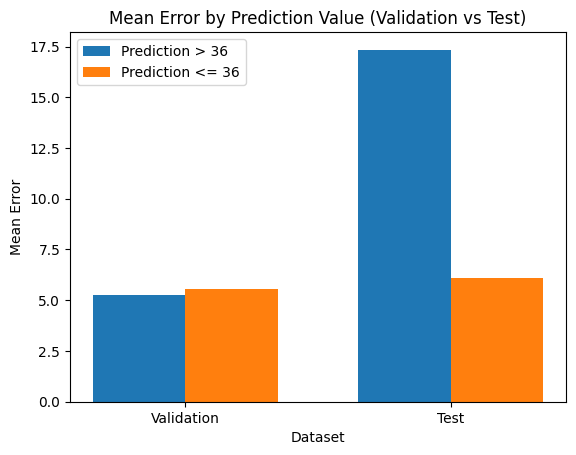

In [17]:
# calculate the mean error when the prediction is higher than the 36 for val and test and also when prediction is lower than 36, then plot the results
mean_error_val_high = df_val[df_val['prediction'] > 36]['error'].mean()
mean_error_val_low = df_val[df_val['prediction'] <= 36]['error'].mean()

mean_error_test_high = df_test[df_test['prediction'] > 36]['error'].mean()
mean_error_test_low = df_test[df_test['prediction'] <= 36]['error'].mean()

fig, ax = plt.subplots()

# Create a bar plot with the validation and test bars side by side
bar_width = 0.35
x = np.arange(2)

ax.bar(x - bar_width/2, [mean_error_val_high, mean_error_test_high], bar_width, label='Prediction > 36')
ax.bar(x + bar_width/2, [mean_error_val_low, mean_error_test_low], bar_width, label='Prediction <= 36')

# Set the x-axis tick labels
ax.set_xticks(x)
ax.set_xticklabels(['Validation', 'Test'])

plt.xlabel('Dataset')
plt.ylabel('Mean Error')
plt.title('Mean Error by Prediction Value (Validation vs Test)')
plt.legend()

plt.show()